# Assessing regression
We study here, both theoretically and with examples, the problem of evaluating the result of a regression task (not necessarily linear although linear regression will be used as running example)

## Preliminaries
Let $f:\mathcal{X} \rightarrow \mathcal{Y}$ be a function and let $\tilde{f}:\mathcal{X} \rightarrow \mathcal{Y}$ be an estimate of $f$. If we use the *square error* metric we can measure the discrepancies between $f$ and $\tilde{f}$ by
\begin{align*}
SE(f,\tilde{f}) = \int_{x\in\mathcal{X}}{(f(x)-\tilde{f}(x))^2dx}
\end{align*}
For a finite discrete number of points $(\mathbf{X},\mathbf{y}) = (x_1,y_1),\ldots,(x_m,y_m)$
\begin{align*}
MSE((\mathbf{X},\mathbf{y}),\tilde{f}) = \frac{1}{m}\sum_{i=1}^{m}{(y_i-\tilde{f}(x_i))^2}
\end{align*}

We can use ``sklearn`` ``mean_squared_error`` to compute such value. Let make an example using ``LinearRegression`` and ``make_regression``

In [23]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

n_samples=100
n_features=1
std=50

# no bias 
X,y,coef = make_regression(n_samples, n_features, noise=std, coef=True, random_state=22)
linear = LinearRegression(fit_intercept=False)
linear.fit(X,y)
print("MSE((X,y), ~f): {0}".format(mean_squared_error(y,linear.predict(X))))
print("~Coeff:     {0}".format(linear.coef_))
print("Real Coeff. {0}".format(coef))

MSE((X,y), ~f): 1819.8172456757657
~Coeff:     [32.81340967]
Real Coeff. 39.80551570183919


/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


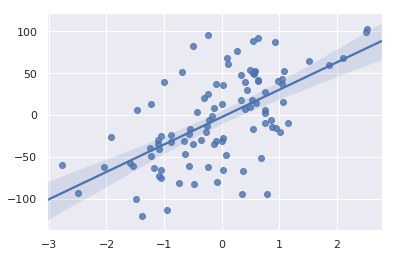

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.regplot(X,y)

## Bias-Variance decomposition
The first generalization of the above model is obtained adding some random normally distributed noise $\eta_i \sim \mathcal{N}(0,\sigma)$ (however the reasoning following holds for any noise that has zero mean with all noises independent and with same variance $\sigma^2$). Thus
\begin{align*}
y_i = f(x_i) + \eta_i
\end{align*}
The mean squared error becomes
\begin{align*}
MSE = \frac{1}{m}\sum_{i=1}^{m}{\left(f(x_i) + \eta_i - \tilde{f}(x_i)\right)^2}
\end{align*}
Which, once expanded, has three addends for each term of the summation
* $(f(x_i)-\tilde{f}(x_i))^2$ the error when there isn't any noise: this is called **bias squared** or $bias^2$
* $\eta_i^2$ which for zero mean noise has expectation equal to the variance $\sigma_i^2$
* $2\eta_i(f(x_i)-\tilde{f}(x_i))$ which for zero mean and independent (**can we be sure of such independcy?**) noise has expectation zero
In expectation the mean squared error becomes
\begin{align*}
MSE = \frac{1}{m}\sum_{i=1}^{m}{\left(f(x_i)-\tilde{f}(x_i)\right)^2} + \sigma^2 = Bias^2 + Variance
\end{align*}

In [25]:
variance = std**2
bias_squared = mean_squared_error(coef*X,linear.predict(X))
print("Bias^2 {0}\nVariance {1}\nMSE = {2}".format(bias_squared, variance, bias_squared+variance))

Bias^2 47.5349477049357
Variance 2500
MSE = 2547.534947704936


The mean squared error obtained with the bias-variance decomposition is different from the actual one because of the randomness of noise (*i.e.* the $\eta_i$ which are now all used via their variance). We see that, in our example, most of the error comes from the variance indicating that we are making a good prediction. What happens when the generating model is not linear?

## Non linear generating models and *model bias*

Conceptually this step is quite simple, in fact we are saying that the model for prediction $\tilde{f}$ is chosen from a class that may not contain the real function $f$ (for example $f$ is not linear, but we use $\tilde{f}$ from the set $\mathcal{H}$ of linear functions in $\mathcal{X}$). 
\begin{align*}
\tilde{f}(x_i) = f(x_i) - \rho(x_i)
\end{align*}
thus
\begin{align*}
f(x_i) - \tilde{f}(x_i) = \rho(x_i)
\end{align*}
We see that the *residuals* $f(x_i)-\tilde{f}(x_i)$ is in fact the *error function* $\rho(x_i)$ which we call the **model bias**. This means that the sum of squared residuals is the *energy* of the noise. We know that when the energy of the noise is much larger than the energy of the signal, we cannot reconstruct the original signal (at least not with arbitrary precision). Even if we were able to find the exact value of the bias squared (and we have seen above that this is not entirely possible), there will be stll the problem of finding the part of the bias that comes from the model bias and which part comes from the model itself. This problem is somehow embedded in the following question: *given a set of points $(x_1,y_1),\ldots,(x_m,y_m)$ can we estimate the model bias $\rho(x_i)$ or the expected model bias $E[\rho(x)]$?*

The above question may be not well posed, consider in fact the case with statistical noise $\eta_i$, then the same analysis we have done for the bias-variance decomposition gives
\begin{align*}
E[(y_i-\tilde{f}(x_i))^2] = E[\rho^2(x_i)] + \sigma_i^2 = Bias^2 + Variance
\end{align*}
Again: the mean squared error can be (in expectation) decomposed into two terms (we still call bias squared and variance), in this case, however, the bias is exactly our model bias which, of course, is intuitive since we defined it as being the discrepancy between the real model that generated the data and the model $\tilde{f}$ we use for prediction.

### Predicting *model bias* using population variance
Of course it is possible to estimate the $Bias^2$ term if we could estimate the $Variance$ term. A first attempt in estimating the variance is by using the population sample variance
\begin{align*}
\bar{\sigma}^2 = \frac{1}{m-1}\sum_{i=1}^{m}{(y_i - \bar{y})^2}
\end{align*}
where $\bar{y}$ is the sample mean
\begin{align*}
\bar{y} = \frac{1}{m}\sum_{i=1}^{m}{y_i}
\end{align*}
Thus the estimate of the 

In [31]:
MSE = mean_squared_error(y, linear.predict(X))
print("Sample mean:     {0}".format(np.mean(y)))
print("Sample variance: {0}".format(np.var(y)))
print("MSE: {0}".format(MSE))
print("Bias squared est. {0}".format(MSE-np.var(y)))

Sample mean:     -4.162268805298162
Sample variance: 2849.3795814341775
MSE: 1819.8172456757657
Bias squared est. -1029.5623357584118


We observe here a strange phenonmen: the estimate of bias squared being negative. This is due to the fact that our estimate of the variance term is too high in fact the real variance would be $2500$, however even the true (usually unknown) value of the variance would give a negative bias squared. This phenomenon is quite suspicous and may sound like overfitting. We could try a regularized regression to see if this phenomenon is alleviated.

In [40]:
from sklearn.linear_model import RidgeCV
alphas = [0.01, 0.1, 1, 10, 100]
ridge = RidgeCV(alphas=alphas, fit_intercept=False)
ridge.fit(X,y)
print("Ridge coeff. {0}".format(ridge.coef_))
ridge_MSE = mean_squared_error(y, ridge.predict(X))
print("Ridge MSE: {0}".format(ridge_MSE))
print("Rdige bias squared est. {0}".format(ridge_MSE-np.var(y)))

Ridge coeff. [32.47936045]
Ridge MSE: 1819.9257427253478
Rdige bias squared est. -1029.4538387088296


The results didin't changed too much, in fact the ridge regression performs (almost) exactly as the ordinary regression with very close squared error. 

### Estimating *model bias* using variance on prediction
An interesting alternative (with no theoritical support whatsoever though) is to estimate the $Variance$ by using the variance of the predicted values $\tilde{y}_i = \tilde{f}(x_i)$.

In [42]:
pred_var = np.var(linear.predict(X))
print("Prediction variance: {0}".format(pred_var))
print("Bias squared est. {0}".format(MSE-pred_var))

Prediction variance: 1043.7847351037324
Bias squared est. 776.0325105720333


On the opposite side of the spectrum, we see that the variance of the predictions $\tilde{y}_i$ appear much smaller than the variance of the real values $y$, why is that the case? The corresponding estimate of the bias square is positive and seems more reasonable, however it is still a result with no theoretical support (at least not one that I can give)

## Scoring and coefficient of determination